# 1. Linear model, predicting coin prices from BTC price 

## Imports

Import pacakges

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('../')

import pystan
import stan_utility

## Data

Initialize data

In [30]:

data = pd.read_csv('/home/jonatan/projects/school/BDA_Project/data/selected/combined.csv', delimiter=",")
data.columns = ['date', 'LTC mCap', 'LTC price', 'LTC  exVol',
       'LTC fees', 'LTC  txVol', 'ETH mCap',
       'ETH price', 'ETH exVol', 'ETH fees',
       'ETH txVol', 'ETC mCap', 'ETC price',
       'ETC exVol', 'ETC fees', 'ETC txVol',
       'DASH mCap', 'DASH price', 'DASH exVol',
       'DASH fees', 'DASH txVol', 'BTC mCap',
       'BTC price', 'BTC exVol', 'BTC fees',
       'BTC txVol']
data=data[['date', 'BTC price','LTC price','DASH price','ETH price','ETC price']]

print(data.head(5))
data.drop(columns=['date'], inplace=True)
data = (data - data.mean()) / (data.max() - data.min())

         date  BTC price  LTC price  DASH price  ETH price  ETC price
0  2016-07-24     655.41       4.06        9.36      14.30   0.752345
1  2016-07-25     661.26       4.07        9.24      12.74   0.931993
2  2016-07-26     654.23       4.04        9.15      13.82   0.604737
3  2016-07-27     651.63       3.96        8.90      12.05   2.460000
4  2016-07-28     654.49       3.97        9.15      12.98   1.560000


In [31]:
n = data.shape[0]
m = 5
x = data[['BTC price']].values.flatten()[0:n]
y1 = data[['DASH price']].values.flatten()[0:n]
y2 = data[['LTC price']].values.flatten()[0:n]
y3 = data[['ETH price']].values.flatten()[0:n]
y4 = data[['ETC price']].values.flatten()[0:n]
p = np.linspace(data[['BTC price']].min(), data[['BTC price']].max(), m)
print(p)

[-0.2302735  0.0197265  0.2697265  0.5197265  0.7697265]


## Read and display edited stan code


In [32]:
with open('lin_t.stan') as file:
    print(file.read())

// Linear student-t model
data {
    int<lower=0> N; // number of data points
    int<lower=0> M;	// number of prediction points
    vector[N] x; //
    vector[N] y; //
    vector[M] xpreds; // input location for prediction
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
    real<lower=1, upper=80> nu;
}
transformed parameters {
    vector[N] mu;
    mu = alpha + beta*x;
}
model {
    nu ~ gamma(2, 0.1); // Juarez and Steel(2010)
    y ~ student_t(nu, mu, sigma);
}
generated quantities {
    vector[M] ypreds;
    vector[N] log_lik;
    for(i in 1:M) {
        ypreds[i] = normal_rng(alpha + beta*xpreds[i], sigma);
    }
    for (i in 1:N){
        log_lik[i] = student_t_lpdf(y[i] | nu, mu[i], sigma);
    }
}



## Generate model

In [33]:
model = stan_utility.compile_model('lin_t.stan')

Using cached StanModel


## Set model data

In [34]:
data1 = dict(N=n,M=m,x=x,y=y1,xpreds=p)
fit1 = model.sampling(data=data1, seed=74749)
samples1 = fit1.extract(permuted=True)

data2 = dict(N=n,M=m,x=x,y=y2,xpreds=p)
fit2 = model.sampling(data=data2, seed=74749)
samples2 = fit2.extract(permuted=True)

data3 = dict(N=n,M=m,x=x,y=y3,xpreds=p)
fit3 = model.sampling(data=data3, seed=74749)
samples3 = fit3.extract(permuted=True)

data4 = dict(N=n,M=m,x=x,y=y4,xpreds=p)
fit4 = model.sampling(data=data4, seed=74749)
samples4 = fit4.extract(permuted=True)

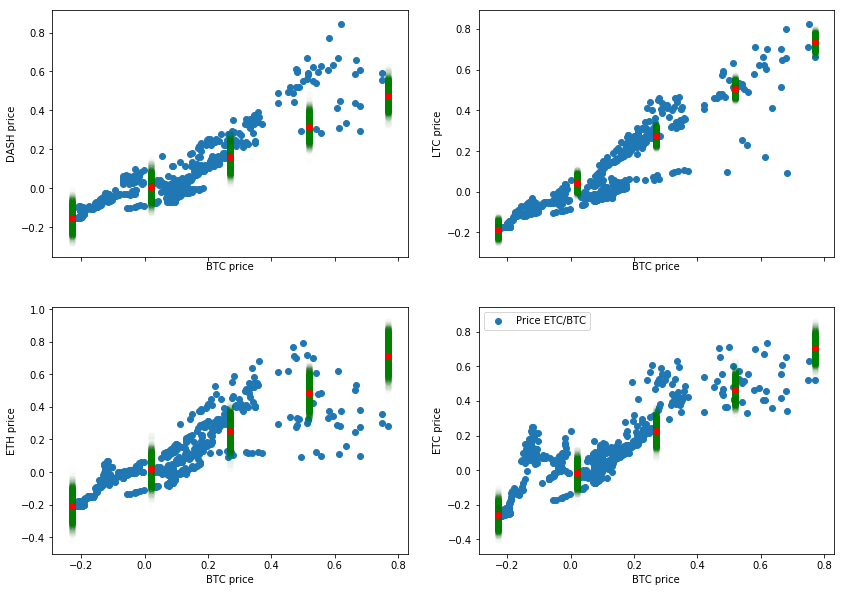

In [35]:
f, axes = plt.subplots(2, 2, figsize=(14,10), sharex=True)
preds = samples1['ypreds'].T
ax = axes[0,0]
ax.scatter(data['BTC price'], data['DASH price'], label='Price DASH/BTC')
ax.set_ylabel('DASH price')
ax.set_xlabel('BTC price')
for i in range(m):
    ax.scatter([p[i]]*len(preds[i]),preds[i], alpha=0.01, c='g')
    ax.scatter(p[i],np.mean(preds[i]), c='r')

preds = samples2['ypreds'].T
ax = axes[0,1]
ax.scatter(data['BTC price'], data['LTC price'], label='Price LTC/BTC')
ax.set_ylabel('LTC price')
ax.set_xlabel('BTC price')
for i in range(m):
    ax.scatter([p[i]]*len(preds[i]),preds[i], alpha=0.01, c='g')
    ax.scatter(p[i],np.mean(preds[i]), c='r')
    
preds = samples3['ypreds'].T
ax = axes[1,0]
ax.scatter(data['BTC price'], data['ETH price'], label='Price ETH/BTC')
ax.set_ylabel('ETH price')
ax.set_xlabel('BTC price')
for i in range(m):
    ax.scatter([p[i]]*len(preds[i]),preds[i], alpha=0.01, c='g')
    ax.scatter(p[i],np.mean(preds[i]), c='r')
    
preds = samples4['ypreds'].T
ax = axes[1,1]
ax.scatter(data['BTC price'], data['ETC price'], label='Price ETC/BTC')
ax.set_ylabel('ETC price')
ax.set_xlabel('BTC price')
for i in range(m):
    ax.scatter([p[i]]*len(preds[i]),preds[i], alpha=0.01, c='g')
    ax.scatter(p[i],np.mean(preds[i]), c='r')
    
plt.legend(loc='best')
plt.show()

## Plot ypred histogram

In [36]:
# plot beat histogram
#fig, ax = plt.subplots(1, 1, figsize=(10,8))

# plot post pred histogram
#ax.set_xlabel('ypred')
#ax.set_ylabel('')
#ax.set_yticks([])
#ax.set_xticks(np.linspace(200, 1000, 10))
#ax.grid(axis='x')
#s = pd.Series(preds[5])
#ax.hist(s, bins=50)
#plt.show()


In [37]:
from psis import psisloo

In [38]:
loglik = samples1['log_lik']
loo1, loos, ks = psisloo(loglik)
print("Loo: {}".format(loo1))

Loo: 1098.4969045792063


In [39]:
ks1 = [[
(ks <= 0.5).sum(),
sum([1 for k in ks if k > 0.5 and k <= 0.7]),
(ks > 0.7).sum()]]
pd.DataFrame(ks1,
columns=["k<=0.5","0.5<k<=0.7","0.7<k"])
print(ks)

[-0.18878646 -0.18433348 -0.18855589 -0.18752927 -0.1886505  -0.18922662
 -0.1886837  -0.18864086 -0.18825959 -0.18591504 -0.18598802 -0.1875845
 -0.18527478 -0.18781321 -0.18721342 -0.185867   -0.18568518 -0.18725045
 -0.18546726 -0.18591147 -0.18542848 -0.18612534 -0.17837906 -0.18026749
 -0.18620961 -0.1858133  -0.17825009 -0.17935953 -0.18619773 -0.18453997
 -0.17786196 -0.18498983 -0.18518407 -0.1854247  -0.18583509 -0.18551648
 -0.18652457 -0.18509591 -0.18583752 -0.18485974 -0.18591344 -0.18474881
 -0.18651138 -0.18649062 -0.18727812 -0.18565877 -0.18453237 -0.18430862
 -0.18537614 -0.18399528 -0.18570729 -0.18599363 -0.18310155 -0.18580131
 -0.18567328 -0.18546506 -0.18727232 -0.18756068 -0.18788589 -0.18567667
 -0.18649578 -0.18702303 -0.18613059 -0.18574883 -0.18727134 -0.18807283
 -0.18522717 -0.1852699  -0.18609673 -0.18628274 -0.18799479 -0.18686922
 -0.18630277 -0.18712793 -0.18694597 -0.18681894 -0.1879446  -0.18637247
 -0.18603032 -0.18599586 -0.18608427 -0.18565238 -0.

In [29]:
S = np.size(loglik, 0)
lppd = sum(np.log([1/S*sum(np.exp(col)) for col in loglik.T]))
p_loocv = lppd - loo1
print(p_loocv)

5.670157265205489
